In [1]:
from importlib import reload

import numpy as np
import pandas as pd
import graph_tool.all as gt
import matplotlib.pyplot as plt

from gptomics import graph, plot

In [2]:
M125 = pd.read_csv("../data/slurm/gpt-neo-125M_compositions_orig.csv.gz", index_col=0, compression="gzip")
B1p3 = pd.read_csv("../data/slurm/gpt-neo-1.3B_compositions_orig.csv.gz", index_col=0, compression="gzip")
B2p7 = pd.read_csv("../data/slurm/gpt-neo-2.7B_compositions_orig.csv.gz", index_col=0, compression="gzip")
J = pd.read_csv("../data/slurm/gpt-j-6B_compositions_orig.csv.gz", index_col=0, compression="gzip")

In [3]:
M125.head()

,src_type,src_block,src_index,dst_type,dst_block,dst_index,term_type,term_value
0,layernorm_bias,0,0,att_head,0,0,Q,0.040065
1,layernorm_bias,0,0,att_head,0,1,Q,0.068386
2,layernorm_bias,0,0,att_head,0,2,Q,0.033579
3,layernorm_bias,0,0,att_head,0,3,Q,0.053598
4,layernorm_bias,0,0,att_head,0,4,Q,0.052785


In [4]:
B1p3.head()

,src_type,src_block,src_index,dst_type,dst_block,dst_index,term_type,term_value
0,layernorm_bias,0,0,att_head,0,0,Q,0.032597
1,layernorm_bias,0,0,att_head,0,1,Q,0.024253
2,layernorm_bias,0,0,att_head,0,2,Q,0.035786
3,layernorm_bias,0,0,att_head,0,3,Q,0.042509
4,layernorm_bias,0,0,att_head,0,4,Q,0.039592


In [5]:
def ipc_plot(gs, percs, ceil, vertex_mask):
    percs = graph.ipc_percentiles(gs, percs, vertex_mask, ceil)
    
    plot.plot_ipc_percentiles(percs)

    
def ipc_analysis(g, ceil, xmin=70):
    
    num_blocks = int(g.vertex_properties["block"].a.max()) + 1
    percs = [0, 25, 50, 75, 100]
    
    plt.subplot(2, 3, 1)
    ipc_plot(graph.value_perc_thresholds(g), percs, ceil, None)
    plt.title("All vertices", fontsize=20)
    if xmin is not None:
        plt.xlim(xmin, 100)
    
    plt.subplot(2, 3, 4)
    ipc_plot(graph.random_removal(g), percs, ceil, None)
    plt.xlabel("Random edge removal")
    if xmin is not None:
        plt.xlim(xmin, 100)
    
    plt.subplot(2, 3, 2)
    ipc_plot(
        graph.value_perc_thresholds(g),
        percs,
        ceil,
        g.vertex_properties["block"].a >= num_blocks // 2,
    )
    plt.title("Second half", fontsize=20)
    if xmin is not None:
        plt.xlim(xmin, 100)
    
    plt.subplot(2, 3, 5)
    ipc_plot(
        graph.random_removal(g),
        percs,
        ceil,
        g.vertex_properties["block"].a >= num_blocks // 2,
    )
    plt.xlabel("Random edge removal")
    if xmin is not None:
        plt.xlim(xmin, 100)
    
    plt.subplot(2, 3, 3)
    ipc_plot(
        graph.value_perc_thresholds(g),
        percs,
        ceil,
        g.vertex_properties["block"].a >= (num_blocks // 4) * 3
    )
    plt.title("Last quarter", fontsize=20)
    if xmin is not None:
        plt.xlim(xmin, 100)
    
    plt.subplot(2, 3, 6)
    ipc_plot(
        graph.random_removal(g),
        percs,
        ceil,
        g.vertex_properties["block"].a >= (num_blocks // 4) * 3
    )
    plt.xlabel("Random edge removal")
    if xmin is not None:
        plt.xlim(xmin, 100)


In [6]:
def read_att_graph(comp_filename):
    df = pd.read_csv(comp_filename, index_col=0, compression="gzip")
    attdf = df[(df.src_type == "att_head")
               & (df.dst_type == "att_head")]
    
    return graph.pair_term_graph(attdf)

In [7]:
from importlib import reload
reload(graph)

<module 'gptomics.graph' from '/home/nt/Work/research/gpt-omics/gptomics/graph.py'>

In [8]:
M125g = graph.pair_term_graph(M125)
B1p3g = graph.pair_term_graph(B1p3)
B2p7g = graph.pair_term_graph(B2p7)
Jg = graph.pair_term_graph(J)

In [9]:
def gptneo_ceil(graph, layernorms=True):
    ceil = list()
    for b, t in zip(graph.vertex_properties["block"], graph.vertex_properties["type"]):
        if t == "layernorm_bias":
            ceil.append(0)
        elif t == "att_bias":
            ceil.append(0)
        elif t == "mlp_bias":
            ceil.append(0)
            
        elif t == "att_head":
            ceil.append(2 * b + layernorms)

        elif t == "mlp_weight":
            ceil.append(2 * b + 1 + layernorms)

        else:
            raise ValueError(f"unknown type: {t=}")
            
    return np.array(ceil)

def gptj_ceil(graph, layernorms=True):
    ceil = list()
    for b, t in zip(graph.vertex_properties["block"], graph.vertex_properties["type"]):
        if t == "layernorm_bias":
            ceil.append(0)
        elif t == "att_bias":
            ceil.append(0)
        elif t == "mlp_bias":
            ceil.append(0)
            
        elif t == "att_head":
                ceil.append(b + layernorms)

        elif t == "mlp_weight":
                ceil.append(b + layernorms)

        else:
            raise ValueError(f"unknown type: {t=}")
            
    return np.array(ceil)

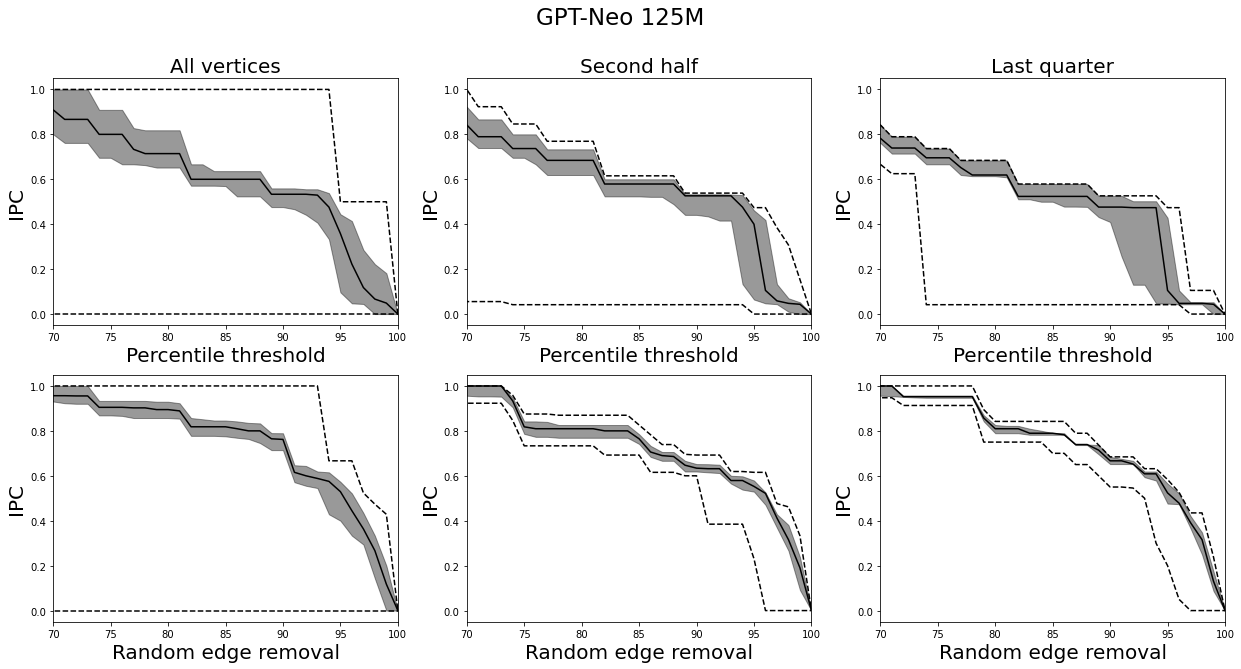

In [10]:
plt.figure(figsize=(21, 10))

ipc_analysis(M125g, gptneo_ceil(M125g), xmin=70)
plt.suptitle("GPT-Neo 125M", fontsize=23)
plt.show()

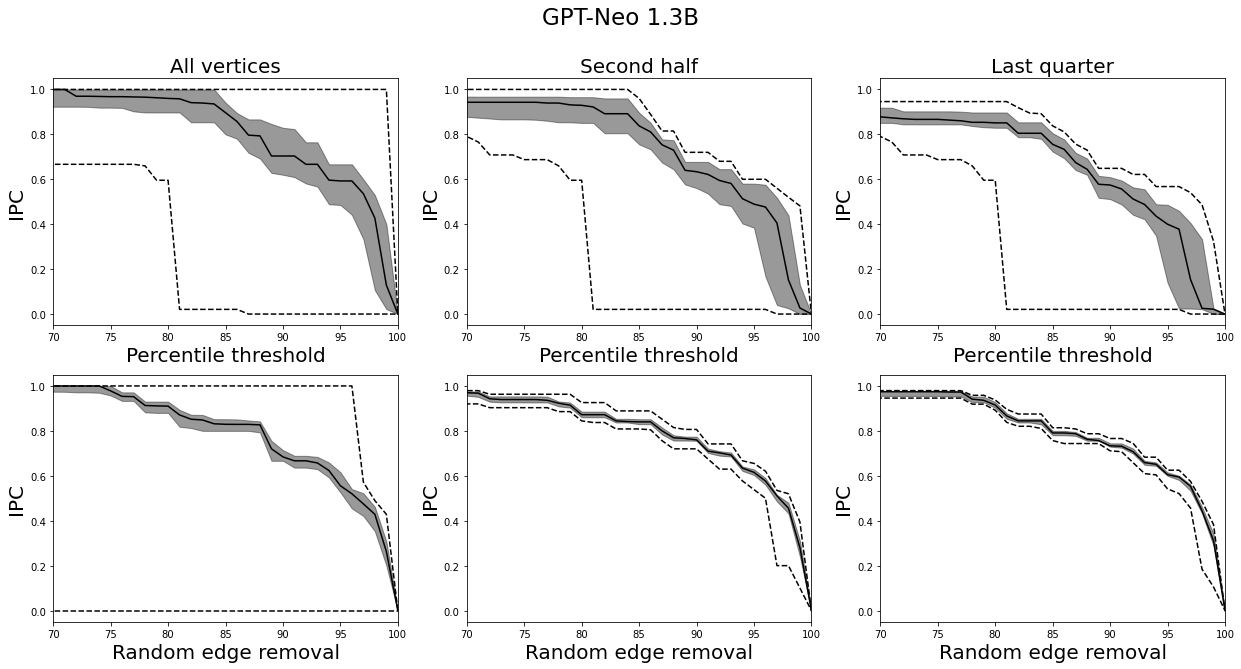

In [11]:
plt.figure(figsize=(21, 10))
ipc_analysis(B1p3g, gptneo_ceil(B1p3g), xmin=70)
plt.suptitle("GPT-Neo 1.3B", fontsize=23)
plt.show()

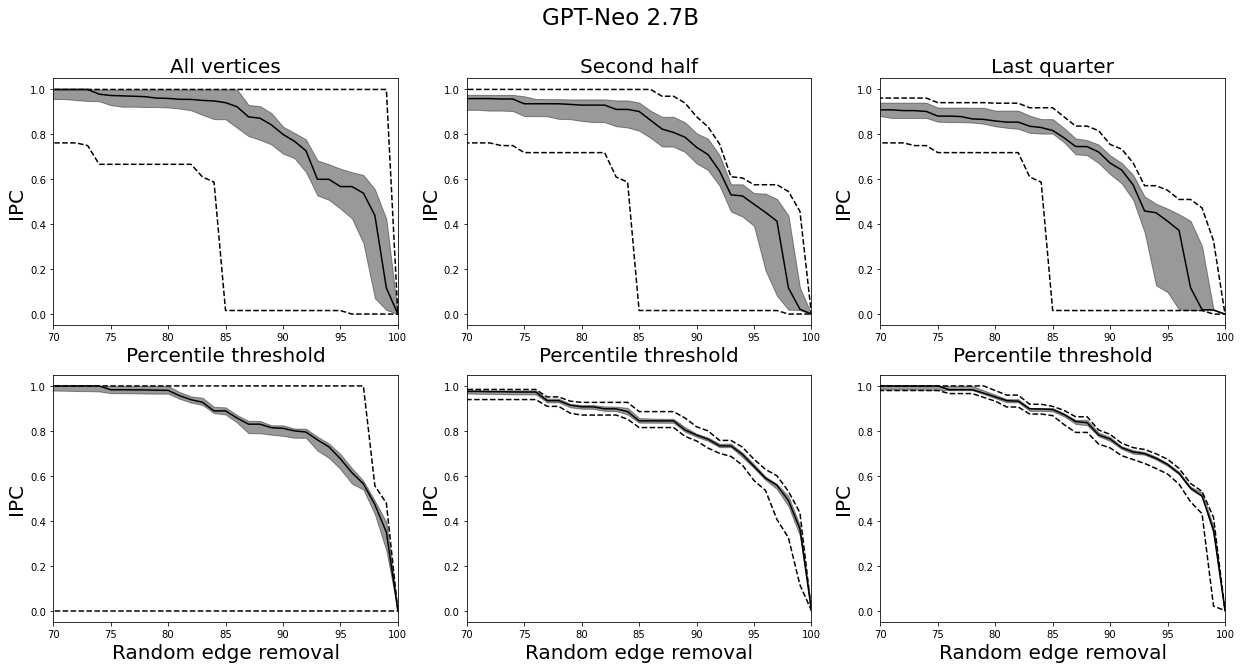

In [12]:
plt.figure(figsize=(21, 10))
ipc_analysis(B2p7g, gptneo_ceil(B2p7g), xmin=70)
plt.suptitle("GPT-Neo 2.7B", fontsize=23)
plt.show()

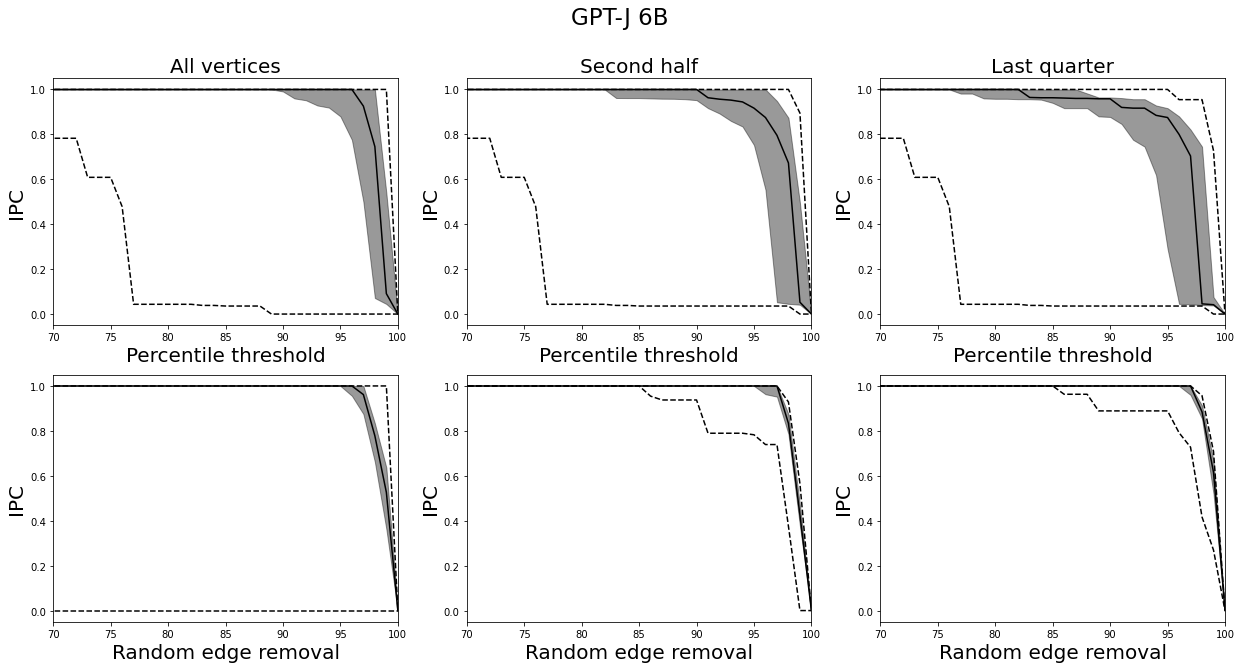

In [13]:
plt.figure(figsize=(21, 10))
ipc_analysis(Jg, gptj_ceil(Jg), xmin=70)
plt.suptitle("GPT-J 6B", fontsize=23)
plt.show()